# 信号空间的数据结构

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

import btnt
import timedomain as td
from qiplot import *
from qisignal import *
from interval import interval
import utils
plt.style.use(['ggplot','../../presentation.mplstyle'])

## 时间域
### 时间轴上的切割
如前所说，整个时间轴上的第$j$层的切割如下：

$$
I_{j,k}\defeq\left[\frac{k}{2^j},\frac{k+1}{2^j}\right];\quad\R=\bigcup_{k\in\Z}I_{j,k}
$$

并且我们有上下层的关系，

$$
I_{j,k}=I_{j+1,2k}\bigcup I_{j+1,2k+1}
$$

这里我们只考虑区间$I=[0,1]$（对应于上面公式中的$I_{0,0}$）切割的问题，并且针对有限$N$个采样点，将时间域转换成正整数域：$[0,1,\cdots,N-1]$。对采样点的假设:

1. 采样点$i\in[0,1,\cdots,N-1]$对应于$t_i\in[0,1]$或$[0,1)$，

    $$
    t_i=\left\{
    \begin{array}{ll}
    \dfrac{i}{N-1},&[0,1]\ \textrm{的情形}\\
    \dfrac{i}{N},&[0,1)\ \textrm{的情形}
    \end{array}
    \right.
    $$

    即采样频率分别为$\Delta t=i/(N-1)$和$\Delta t=i/N$。

2. $N=2^L$，其中$L\in\N$。

在连续域上，根据上面的$I_{0,0}$，第$j$层的分割为

$$
I=\bigcup_{k=0}^{2^j-1}I_{j,k},\quad I_{j,k}=\left[\frac{k}{2^j},\frac{k+1}{2^j}\right]
$$

$j$与$j+1$层的递归关系为$I_{j,k}=I_{j+1,2k}\bigcup I_{j+1,2k+1}，k\in[0,1,\cdots,2^j]$。

连续域上的切割区间节点与我们的采样点是吻合的（对应与$[0,1)$采样的情形），因此在整数域上的切割为：

$$
\begin{array}{lll}
\textrm{第0层}&I_{0,0}=[0,1,\cdots,2^L-1]\\
\textrm{第1层}&I_{1,0}=[0,1,\cdots,2^{L-1}-1],\quad I_{1,1}=[2^{L-1},2^{L-1}+1,\cdots,2^L-1]\\
\cdots&\cdots\\
\textrm{第$j$层}&I_{j,0},I_{j,1},\cdots,I_{j,2^j-1},\quad I_{j,k}=[2^{L-j}k,\cdots,2^{L-j}(k+1)-1],\quad k\in[0,1,\cdots,2^j-1]\\
\cdots&\cdots\\
\textrm{第$L$层}&I_{L,0},I_{L,1},\cdots,I_{L,2^L-1},\quad I_{L,k}=[k],\quad k\in[0,1,\cdots,N-1]
\end{array}
$$

递归公式为$I_{j,k}=I_{j+1,2k}\bigcup I_{j+1,2k+1}$，也就是给定$I_{j,k}$，可以生成左右两个子区间分别是$I_{j+1,2k}$和$I_{j+1,2k+1}$。左子区间取当期区间$I_{j,k}$的左半部，右子区间取右半部。

我们用二叉树来实现这个分割逻辑，作为一个例子，以上的递归关系用以下的`left_half`和`right_half`函数来实现。通过`btnt.makebtnt`函数来产生对任意的数组$[0,1,\cdots,N-1]$建立一个二叉树来实现以上的分割。

这里`btn`是二叉树的节点数据结构，用一个简单的类来实现，其中包括类的几个参数：
- `content`：节点的内容，可以是任意的数据类
- `left`：左子节点，数据类为`btn`
- `right`：右子节点，数据类为`btn`
- `tag`：节点的标识，可以是任意的数据类

```{code-block} python
---
name: btn
linenos: True
caption: |
    类`btn`源代码
---
class btn:
    def __init__(self,content: Any,left: btn,right: btn,tag: Any):
        self.content=content
        self.left=left
        self.right=right
        self.tag=tag
```

下面是产生二叉树的函数（builder），输入参数：
- `level`：二叉树的层数，数据类为`int`。如果应用于上面的时间域的分割，`level`小于或等于$L$。
- `content`：根节点的内容，数据类为`Any`。
- `lp`：根据当期内容，产生左子节点内容，一个`content`类=>`content`类的函数
- `rp`：根据当期内容，产生右子节点内容，一个`content`类=>`content`类的函数

输出为`root`，二叉树的根节点，数据类是`btn`。

```python
def makebtnt(level,content,lp,rp):
    if not isinstance(level,int) or level<0:
        raise ValueError('invalid input in makebtnt')
    root = btn(content,None,None,None)
    if level>0:
        root.left=makebtnt(level-1,lp(content),lp,rp)
        root.right=makebtnt(level-1,rp(content),lp,rp)
    return root
```

这是第一个版本，有一个小瑕疵，就是不能产生没有内容的二叉树。改进的代码如下：

```{code-block} python
---
name: makebtnt
linenos: True
caption: |
    `makebtnt`源代码
---
def makebtnt(level,content=None,lp=None,rp=None):
    if not isinstance(level,int) or level<0:
        raise ValueError('invalid input in makebtnt')
    root = btn(content,None,None,None)
    if level>0:
        if lp!=None:
            root.left=makebtnt(level-1,lp(content),lp,rp)
        else:
            root.left=makebtnt(level-1,None,lp,rp)
        if rp!=None:
            root.right=makebtnt(level-1,rp(content),lp,rp)
        else:
            root.right=makebtnt(level-1,None,lp,rp)
    return root
```

关于二叉树的数据结构在`btnt`程序包里（即文件`btnt.py`）。

In [2]:
def left_half(t):
    if t==None:
        return None
    n=len(t)
    if not btnt.ispower2(n):
        raise ValueError("input must be power of 2")
    n>>=1
    return t[0:n]

def right_half(t):
    if t==None:
        return None
    n=len(t)
    if not btnt.ispower2(n):
        raise ValueError("input must be power of 2")
    n>>=1
    return t[n:len(t)]

In [3]:
t=list(range(8))
left_half(t)

[0, 1, 2, 3]

In [4]:
right_half(t)

[4, 5, 6, 7]

In [5]:
root=btnt.makebtnt(3,t,left_half,right_half)
btnt.print_level_order(root)

[0, 1, 2, 3, 4, 5, 6, 7] 

[0, 1, 2, 3] [4, 5, 6, 7] 

[0, 1] [2, 3] [4, 5] [6, 7] 

[0] [1] [2] [3] [4] [5] [6] [7] 



In [6]:
foo=btnt.makebtnt(3,None,None,None)
btnt.height(foo)

4

In [7]:
btnt.print_level_order(foo)

None 

None None 

None None None None 

None None None None None None None None 



In [8]:
foo=btnt.makebtnt(3,t,None,None)
btnt.print_level_order(foo)

[0, 1, 2, 3, 4, 5, 6, 7] 

None None 

None None None None 

None None None None None None None None 



In [9]:
foo=btnt.makebtnt(3,t,left_half,None)
btnt.print_level_order(foo)

[0, 1, 2, 3, 4, 5, 6, 7] 

[0, 1, 2, 3] None 

[0, 1] None None None 

[0] None None None None None None None 



### 一些生成时间域序列的辅助工具
1. `partition`：对以上的分割算法的一个封装，输入参数为一个连续的整数序列，$[0,1,2,\cdots,N-1]$
2. `block`：$I_{j,k}$的获取，输入参数`root`，`level`，`block`，其中`level`，`block`对应于$I_{j,k}$下标，`root`是二叉树的根，即内容为$I_{0,0}$的节点；输出是内容为$I_{j,k}$的节点。
3. `qilinespace`：整数时间序列到实数时间序列的转换，输入参数：`v`，`[a, b]`。其中`v`为被转换的整数序列，要求最后一个数$N-1$，其中$N$是采样点的个数，也要求`v`从小到大排列；$[a,b]$为实数时间域区间，默认为$[0,1]$。输出为转化后的实数时间域序列。

In [10]:
nn=list(range(8))
t=td.qilinespace(nn,[0,2])
t

[0.0,
 0.2857142857142857,
 0.5714285714285714,
 0.8571428571428571,
 1.1428571428571428,
 1.4285714285714284,
 1.7142857142857142,
 2.0]

In [11]:
root=td.partition(nn,3)
i11=td.block(root,1,1)
print(i11.content)

[4, 5, 6, 7]


In [12]:
i20=td.block(root,2,0)
print(i20.content)

[0, 1]


## interval
`interval`数据结构是为截取一段信号而设计，时间域是整数序列，而且允许负整数指针的数据提取。`interval`是不可变更类。

`interval`的参数：
1. `least`：负时间域采样点个数
2. `final`：正时间域采样点个数
3. `zero`：零指针
4. `origin`：对应于时间域的值域数组

```{code-block} python
---
name: interval
linenos: True
caption: |
    `interval`源代码
---
class interval(object):
    def __init__(self,data,least,final):
        """
        Inputs:
        data: data to be copy to origin, data[0]=orgin[least+zero]
        least: the `least` attribute
        final: the `final` attribute
        """
        if not isinstance(least,int) or not isinstance(final,int):
            raise ValueError("Invalid type input in intervel constructor")
        if  least>0 or least>final:
            raise ValueError("Invalid least parameter")
        length=1+final-least
        if length>0 or data is None:
                if len(data)<length:
                    raise ValueError("Invalid input in interval constructor for data")
                self.ORIGIN=np.array(data[0:length],dtype=float)
                self.ORIGIN.flags.writeable=False
        else:
            self.ORIGIIN=None
        self.LEAST=least
        self.FINAL=final
        self.ZERO=-least

    def __len__(self):
        return len(self.ORIGIN)
            
    def __getitem__(self,n):
        if isinstance(n,int):
            if not self.ininterval(n):
                raise ValueError("interval getitem out of bound")
            else:
                return self.ORIGIN[n+self.ZERO]
        elif isinstance(n,slice):
            if n.start==None:
                start=self.LEAST
            else:
                start=n.start
            if n.stop==None:
                stop=self.FINAL
            else:
                stop=n.stop
            if n.step==None:
                step = 1
            else:
                step = n.step
            if self.ininterval(start) and self.ininterval(stop):
                start += self.ZERO
                stop += self.ZERO
                return np.array([self.ORIGIN[i] for i in range(start,stop,step)],dtype=float)
            else:
                raise ValueError("out of bound")
        else:
            raise TypeError("type unkown")

    def ininterval(self,offset):
        if not isinstance(offset,int):
            raise ValueError('invalid input')
        if offset>=self.LEAST and offset<=self.FINAL:
            return True
        else:
            return False
```

参数的意义：
1. 时间域：$\left[\textrm{LEAST},\ \textrm{FINAL}\right]$
2. 值域：$\textrm{ORIGIN}[i],\ i\in\left[\textrm{LEAST},\ \textrm{FINAL}\right]$为时间域的值。
3. 被截取数据`data`与`interval`中`ORIGIN`的关系：$\textrm{data}[i]=\textrm{ORIGIN}\left[\textrm{ZERO}+i],\ i\in[\textrm{LEAST},\ \textrm{FINAL}\right]$。

```{note}
`interval`并没有继承`Immutable`，但是`interval`不可变性是通过将所有成员常数化，包括将时间序列的值域系列设置成不可变更序列，见源代码中的第18行。
```

In [13]:
test_data=list(range(-10,54))
least=-10
final=9

i=interval(test_data,least,final)

In [14]:
len(i)==(i.FINAL-i.LEAST+1)

True

In [15]:
i[0]==test_data[i.ZERO]

True

In [16]:
i[i.LEAST]==test_data[0]

True

In [17]:
i[:5]==test_data[0:(5+i.ZERO)]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [18]:
i[-5:-1]==test_data[i.ZERO-5:i.ZERO-1]

array([ True,  True,  True,  True])

In [19]:
i[i.FINAL]

9.0

In [20]:
print("least=",i.LEAST," zero=",i.ZERO," final=",i.FINAL," len(ORIGIN)=",len(i))

least= -10  zero= 10  final= 9  len(ORIGIN)= 20


In [21]:
i.ininterval(0)

True

`interval`不完全是不可变更的！请看下例。这个问题在下个版本解决。

In [22]:
test_data=list(range(-10,54))
least=-10
final=9

i=interval(test_data,least,final)

data=i.ORIGIN
print("更改前的数据")
print(f"d[0:5]={data[0:5]}")
print(f"ORIGIN[0:5]={i.ORIGIN[0:5]}")
data.flags.writeable=True
data[0]=None
print("更改后的数据：")
print(f"d[0:5]={data[0:5]}")
print(f"ORIGIN[0:5]={i.ORIGIN[0:5]}")

更改前的数据
d[0:5]=[-10.  -9.  -8.  -7.  -6.]
ORIGIN[0:5]=[-10.  -9.  -8.  -7.  -6.]
更改后的数据：
d[0:5]=[nan -9. -8. -7. -6.]
ORIGIN[0:5]=[nan -9. -8. -7. -6.]


## signal
### signal_i
`signal_i`在`interval`的基础上加上一个成员`T`以及一个类方法：`plot`，从某种意义上说`signal_i`只是方便`interval`绘图的类。这个类成员`T`是相应时间域的序列。由于展示时间序列用实数时间域会更有意义，所以一般来说，`signal_i`的成员`T`是实数时间域序列。`signal_i`的构造函数的输入为`t`和`x`，分别是时间序列的时间域和值域序列。构造函数根据`t`来决定参数`LEAST`，`ZERO`，`FINAL`。

```{code-block} python
---
name: signal_i
linenos: True
caption: |
    `signal_i`的源代码
---
class signal_i(interval):
    def __init__(self,t,x):
        if not utils.is_sorted(t):
            raise NameError('time stamp not in order')
        nn=utils.nnegatives(t)
        f = len(t)-nn-1
        l = -nn
        interval.__init__(self,x,l,f)
        if isinstance(t,list):
            self.T=np.array(t,dtype=float)
        elif isinstance(t,np.ndarray):
            self.T=t
        else:
            raise TypeError("known type")
        self.T.flags.writeable=False
    
    def plot(self,ax):
        dd = self.ORIGIN
        plot_ts(ax,self.T,dd)
```

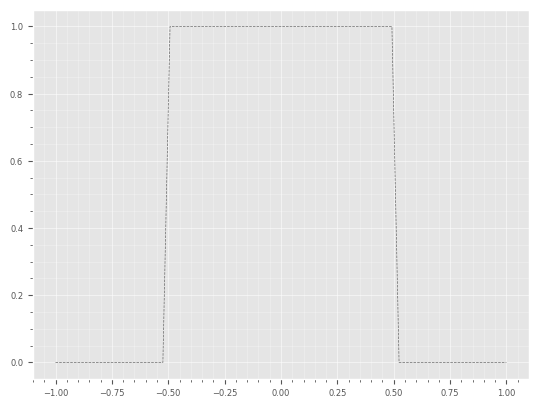

In [23]:
N=64
t=np.linspace(-1,1,N)
x=[1.0 if v>=-0.5 and v<=0.5 else 0.0 for v in t]
sig=signal_i(t,x)
fig,ax=plt.subplots()
sig.plot(ax)

In [24]:
print(sig.LEAST,sig.ZERO,sig.FINAL,len(sig))

-32 32 31 64


### signal_p
`signal_i`的主要功能是截取的信号（输入参数）封装成一个不可变更的对象，并且允许负指针操作。其中负指针的操作是相对零点指针而言。

python数组本身就有负指针的概念和定义。这种定义非常适合周期信号序列，但对排序需要作如下的调整：假设$n$为负时间域采样点个数，$m$为正采样点个数，输入信号$\{x_i,i\in[0,1,\cdots,N-1]\}$，其中$N$为信号的长度，并且$N=m-n+1$。赋予时间的意义，那么输入信号的顺序假设为：

$$
x[-n], x[-n+1],\cdots,x[-1],x[0],x[1],\cdots,x[m]
$$

在`signal_p`中，我们将这个序列变成：

$$
x[0],x[1],\cdots,x[m],x[-n], x[-n+1],\cdots,x[-1]
$$

也就将输入数组以$N$为周期左移$n$。

其中的绘图函数`plot`则是按原来的顺序展示，即`plot`使用右移了$n$的内部数组进行绘图。

```{code-block} python
---
name: signal_p
linenos: True
caption: |
    `signal_p`的源代码
---
class signal_p(object):
    """
    Periodic signal class

    """
    def __init__(self,t,x):
        if len(t)!=len(x):
            raise ValueError("size of t and x are not the same")
        if not utils.is_sorted(t):
            raise NameError('time stamp not in order')
        nn=utils.nnegatives(t)
        f = len(t)-nn-1
        l = -nn
        self.NN=nn
        self.DATA=np.roll(x,l)
        if isinstance(t,list):
            self.T=np.array(t,dtype=float)
        elif isinstance(t,np.ndarray):
            self.T=t
        else:
            raise TypeError("known type")
        self.DATA.flags.writeable=False
        self.T.flags.writeable=False
    
    def __len__(self):
        return len(self.DATA)

    def __getitem__(self,position):
        return self.DATA[position]

    def plot(self,ax):
        plot_ts(ax,self.T,np.roll(self.DATA,self.NN))
```

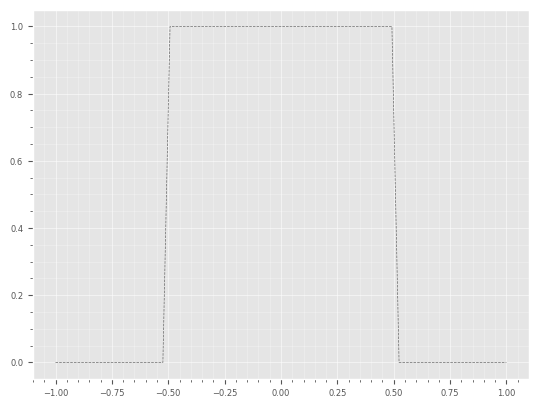

In [25]:
N=64
t=np.linspace(-1,1,N)
x=[1.0 if v>=-0.5 and v<=0.5 else 0.0 for v in t]
sig=signal_p(t,x)
fig,ax=plt.subplots()
sig.plot(ax)

## 函数式
从算法的角度上看，上面关于信号序列的类，`signal_i`和`signal_p`，定义了数组指针的行为。这两个类更多的像一个信号载体，我们对这个载体赋予了一定的特征，不可变更性和指针行为。这些特征还不能满足算法的需求。能不能设计出特征比较丰富（对算法而言）的类（往往是多个类），成为一个课题。

### 算法特征
首先来看看我们的算法特征。所考虑的算法最大的特征就是局部分析，而且是应用成熟的外部程序库中众多的算法进行局部分析。另外一个特征就是按照某种逻辑反复多次的进行这种局部分析，上面看到的对时间域分层切割就是经典的（几乎是是唯一用到的）逻辑。

我们要设计的类就是要针对这些特征进行。

### 算法在信号空间上的单元操作
根据算法的特征，在信号空间上所需的类特征如下：
1. 局部性（localizatioin）
2. 位移（translation）
3. 伸缩或抽样（decimation）
4. 函数式，能够让外部函数作用于内部数据。

### 函数式的实现
特征4通过函数式来实现，容器的内容主要是局部的信号，也就是外部函数作用到局部信号上。具体的实现是设计一个以`tuple`为容器的`functor`。`tuple`中的元素是局部信号，也就是要求元素为`Iterable`。这个类放在`utils`的程序包下，因为其适用性跳出了信号空间的范畴。

```{code-block} python
---
name: functor.Tuple
linenos: True
caption: |
    `functor.Tuple`的源代码
---
from typing import TypeVar, Callable, Generic
from collections.abc import Iterable

A=TypeVar("A")
B=TypeVar("B")

class TimeSeries(Generic[A]):
    pass

class Tuple(TimeSeries[tuple[A]]):
    def __init__(self,sig:tuple[A]):
        if sig!=None:
            if not isinstance(sig,tuple):
                raise TypeError("sig must be tuple")
            self.signal=sig

    def fmap(self,func: Callable[[tuple],tuple])->TimeSeries[tuple[A]]:
        try:
            rs=[]
            for i in self.signal:
                tmp = func(i)
                if tmp==None:
                    continue
                if isinstance(tmp,Iterable):
                    rs.append(tmp)
                else:
                    rs.append((tmp,))
            return Tuple(tuple(rs))
        except Exception as e:
            return ()

    def __iter__(self):
        return iter(self.signal)

```

### 局部性
`blocks`是一个类，对信号进行等分分割并且进行分析。分析能力是通过赋予`functor`的功能来实现。切割函数`chunked`来自于`more_itertools`，跟导言所分析的`grouper`功能是一样的。

```{code-block} python
---
name: blocks
linenos: True
caption: |
    `blocks`的源代码
---
class blocks(functor.Tuple):
    def __init__(self,sig:tuple,B: int):
        if not isinstance(sig,Iterable) or not isinstance(B,int):
            raise TypeError("sig must be tuple, B must be int")
        functor.Tuple.__init__(self,tuple(tuple(i) for i in chunked(sig,B)))
```

In [26]:
N=64
B=16
foo=tuple(range(N))
qif=blocks(foo,B)

In [27]:
tmp=qif.fmap(print)

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)
(16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31)
(32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47)
(48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63)


`decimation`是对数组抽样，每隔一个数抽取一个，下面做了两次这样的抽样，每个数组的个数从$N$变成$N/4$。最后应用`print`将每一组数打印出来。这种组合式的做法简洁明了。

In [28]:
qif.fmap(decimation).fmap(decimation).fmap(print)

(0, 4, 8, 12)
(16, 20, 24, 28)
(32, 36, 40, 44)
(48, 52, 56, 60)


上面所用到的函数`decimation`和`print`叫做应用函数，也就是能够作为`fmap`输入参数的函数。严格来说，对应用函数的要求是能够将`blocks`容器的元素映射到`Iterable`数据类，这个`Iterable`的元素类可以跟原来的类不同。`functor.Tuple`对映像的`Iterable`的要求放宽了一点，也接受空映像和单个数据的情况。这就是为什么`print`可以是一个应用函数。函数`sum`将数组映射成一个数值，同样是`functor.Tuple`的应用函数。

In [29]:
qif.fmap(sum).fmap(print)

120
376
632
888


python的类系统不清晰，也比较松散，有不少隐规则。这是这个语言最大的缺点，当然也有人说是最大的优点。对设计`functo.Tuple`而言，这样的不清晰的类系统挑战很大。我们对应用函数的范围还需要不断摸索。

无论是`decimation`还是`sum`，多次重复应用都会到达一个不变点。我们来看看`blocks`经过大量的重复应用后会怎么样：

In [30]:
tmp=qif.fmap(decimation)
for _ in range(100):
    tmp=tmp.fmap(decimation)

In [31]:
tmp.fmap(print)

(0,)
(16,)
(32,)
(48,)


In [32]:
tmp=qif.fmap(sum)
for _ in range(100):
    tmp=tmp.fmap(sum)
tmp.fmap(print)

Empty....

In [33]:
qif.fmap(int).fmap(str)

Empty....

### 光滑切割
`blocks`满足了block transform的要求。为了能够运用于lct，lst这样的局部分析，我们还需要加功能以满足折叠与扩充（padding）的需求。扩充是在两个端点将数组扩大的方法。新的需求体现在下面两点：
1. 上面的分组，相邻的组没有交集，而折叠算子要求相邻的组有一定的交集。
2. 新的算法由两类算法组成，这两种算法分别是block transform和磨光、延伸。block transform作用于核心区域（也就是原来不做延伸的区域），磨光与延伸作用于延伸区域和一部分核心区域。

从程序设计的角度看，就是要在基础类上加功能。非常适合用traits和组合（mixin）的方法。

#### traits与mixin
扩充目前有三个方法：加零扩充，周期扩充和对称扩充。加零扩充就是用零去设置扩充的区域。严格来说，周期扩展是把数组看成是首尾相接的循环序列，周期为信号的长度，不需要扩充数组的长度。但是通常人们是利用这个概念设置扩充区域的值。对称扩充是以端点为对称点的扩充。完整的对称扩充如下：用符合$x$记信号的值，即$x[0],x[1],\cdots,x[N-1]$为被扩充的数组。对于$0$点进行对称扩充后所得到的数组为$x[N-1],x[N-2],\cdots,x[1],x[0],x[0],x[1],x[2],\cdots,x[N-1]$，也就是得到了长度为$2N$的数组，把这个新的数组看成周期数组，也就是首尾相接的数组，这个数组在端点具备连续性，这就是对称扩充的好处。如果不是做完整的扩充，只是继续$M$个元素的扩充（$M<N$），那么我们只是对端点进行对称操作。

这是三种不同的算法，我们分别用三个函数来实现，用`traits`的方式把这个三种算法封装起来，通过`mixin`，我们可以灵活地赋予一个类具备padding的功能。下面是这个设计思路的实验：

In [34]:
def padding_zero():
    print("this is padding with zero")
def padding_period():
    print("this is periodic padding")
def padding_symetric():
    print("this is symetrical padding")

def has_padding(name, default=None, doc=None):
    """
    Return an anonymous class that has a padding property
    named `name`, with a default value of `default` and
    a docstring of `doc`.
    """

    propname = "__padding_method_{}".format(name)
    padding_method = {
        "zero": padding_zero,
        "period": padding_period,
        "symetric": padding_symetric
    }

    def getter(self):
        return getattr(self, propname, default)

    def setter(self, value):
        if isinstance(value, str):
            if value not in padding_method:
                raise ValueError("unknown padding method '{}'".format(value))
            setattr(self, propname, staticmethod(padding_method[value]))

        else:
            raise TypeError("padding method specifications must be strs")


    class Inner:
        pass

    setattr(Inner, name, property(getter, setter, None, doc))
    return Inner

In [35]:
class Preprocessor:
    pass

class test(Preprocessor,
           has_padding("left"),
           has_padding("right")):
           pass

In [36]:
c=test()

In [37]:
c.left='zero'

In [38]:
type(c.left)

staticmethod

In [39]:
c.left()

this is padding with zero


In [40]:
c.right='symetric'

In [41]:
c.right()

this is symetrical padding


In [42]:
c.left='period'

In [43]:
c.left()

this is periodic padding


In [44]:
c.left

<staticmethod(<function padding_period at 0x7fb90c0c6ac0>)>

基本达到我们的设计要求，但是扩充除了算法外，还有一个关于端点的参数。下面是算法函数的实现，我们基本上只考虑三类数组类型（而且假设是一维数组，这里对类的把握还不是太严密，以后会不断加强）。

#### 扩充算法实现

In [45]:
from functools import partial

def padding_zero(n,size,iterable):
    if isinstance(iterable, np.ndarray):
        return np.zeros(size,dtype=float)
    elif isinstance(iterable, list):
        return [0 for _ in range(size)]
    else:
        return tuple(0.0 for _ in range(size))

def padding_periodic(n,size,iterable):
    if n==0:
        return iterable[-size:]
    elif n==-1:
        return iterable[:size]
    else:
        raise ValueError("unhandled index")

def padding_symetric(n,size,iterable):
    # not sure how to convert a reversed iterator for np.ndarray
    # so use slice ::-1
    if n==0:
        tmp=(iterable[:size])[::-1]
    elif n==-1:
        tmp=(iterable[-size:])[::-1]
    else:
        raise ValueError("unhandled index")
    if isinstance(iterable,np.ndarray):
        return np.array(tmp,dtype=float)
    elif isinstance(iterable,list):
        return list(tmp)
    else:
        return tuple(tmp)

left_zero=partial(padding_zero,0)
right_zero=partial(padding_zero,-1)

left_periodic=partial(padding_periodic,0)
right_periodic=partial(padding_periodic,-1)

left_symetric=partial(padding_symetric,0)
right_symetric=partial(padding_symetric,-1)

In [46]:
from collections import namedtuple

Padding = namedtuple("Padding",["method","at"])
methods= 'zero periodic symetric'.split()
endpoints = 'left right'.split() 
paddings=[Padding(method,at) for method in methods for at in endpoints]

def print_padding_result(size,iterable):
    for i in paddings:
        print(f"{i.at} {i.method}={eval(i.at+'_'+i.method)(size,iterable)}")

In [47]:
foo=list(range(32))
print_padding_result(8,foo)

left zero=[0, 0, 0, 0, 0, 0, 0, 0]
right zero=[0, 0, 0, 0, 0, 0, 0, 0]
left periodic=[24, 25, 26, 27, 28, 29, 30, 31]
right periodic=[0, 1, 2, 3, 4, 5, 6, 7]
left symetric=[7, 6, 5, 4, 3, 2, 1, 0]
right symetric=[31, 30, 29, 28, 27, 26, 25, 24]


In [48]:
foo=tuple(range(32))
print_padding_result(8,foo)

left zero=(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
right zero=(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
left periodic=(24, 25, 26, 27, 28, 29, 30, 31)
right periodic=(0, 1, 2, 3, 4, 5, 6, 7)
left symetric=(7, 6, 5, 4, 3, 2, 1, 0)
right symetric=(31, 30, 29, 28, 27, 26, 25, 24)


In [49]:
foo=np.array(foo,dtype=float)
print_padding_result(8,foo)

left zero=[0. 0. 0. 0. 0. 0. 0. 0.]
right zero=[0. 0. 0. 0. 0. 0. 0. 0.]
left periodic=[24. 25. 26. 27. 28. 29. 30. 31.]
right periodic=[0. 1. 2. 3. 4. 5. 6. 7.]
left symetric=[7. 6. 5. 4. 3. 2. 1. 0.]
right symetric=[31. 30. 29. 28. 27. 26. 25. 24.]


有了扩充算法函数，我们对`traits`做相应的修改，主要是限制`name`只能是`left`或者`right`。

#### padding trait

In [50]:
def use_padding_at(name, default=None, doc=None):
    """
    Return an anonymous class that has a padding property
    named `name`, with a default value of `default` and
    a docstring of `doc`.
    """

    if name!='left' and name!='right':
        raise ValueError("name is either 'left' or 'right'")
    propname = "__padding_method_{}".format(name)

    padding_methods = {
        "left zero": left_zero,
        "left periodic": left_periodic,
        "left symetric": left_symetric,
        "right zero": right_zero,
        "right periodic": right_periodic,
        "right symetric": right_symetric
    }

    def getter(self):
        return getattr(self, propname, default)

    def setter(self, value):
        if isinstance(value, str):
            value=name+' '+value
            if value not in padding_methods:
                raise ValueError("unknown padding method '{}'".format(value))
            setattr(self, propname, staticmethod(padding_methods[value]))
        else:
            raise TypeError("padding method specifications must be strs")

    class Inner:
        pass

    setattr(Inner, name, property(getter, setter, None, doc))
    return Inner


#### 有交集的切割

In [51]:
class oblocks(blocks,use_padding_at("left"),use_padding_at("right")):
    """
    overlapping blocks
    
    """
    def __init__(self,sig,B,ps,pm=['periodic','periodic']):
        blocks.__init__(self,sig,B)
        self.left,self.right=pm
        self.leftsize,self.rightsize=ps
        

In [52]:
foo=np.array(list(range(32)))
c=oblocks(foo,16,[8,8])

In [53]:
print(c.left)
print(c.right)

<staticmethod(functools.partial(<function padding_periodic at 0x7fb90c0c6fc0>, 0))>
<staticmethod(functools.partial(<function padding_periodic at 0x7fb90c0c6fc0>, -1))>


In [54]:
c.fmap(decimation).fmap(print)

(0, 2, 4, 6, 8, 10, 12, 14)
(16, 18, 20, 22, 24, 26, 28, 30)


#### `oblocks`的构造函数
`blocks`将长度为$N$的输入信号切割成长度为$B$的$N/B$个子序列（我们将会对$N$和$B$进行限制：$N=2^L$，$B=2^l$, $l<L$）。`oblocks`在这个基础上，

1. 对每个子序列两端进行扩充，扩充的范围由输入参数`ps`（padding size）决定；
2. 子序列的扩充分三种情况：
    - 第一个子序列：左端点按输入参数`pm`（padding method）中的第一个参数决定扩充方法，右端点外的扩充区域由相邻的第二个子序列的决定（交集部分）。
    - 最后一个序列：右端点按输入参数`pm` 中的第二个参数决定扩充方法，左端点外的扩充区域由倒数第二个子序列决定（交集部分）。
    - 其他子序列的扩充两端都由相邻的子序列决定。
3. 保持`blocks`的子序列，并称之为核心子序列，创建两个新的子序列，分别为左扩充区域子序列和右扩充区域子序列。

以上这些都是在`oblock`构造的时候实施。

In [55]:
from collections import namedtuple
from collections.abc import  Iterable
import typing
from contextlib import contextmanager
from more_itertools import windowed

PaddingParam = typing.NamedTuple("PaddingParam",method=str,size=int)
Edge = typing.NamedTuple("Edge",left=PaddingParam,right=PaddingParam)

def getedge(lm,ls,rm,rs):
    return Edge(left=PaddingParam(method=lm,size=ls),right=PaddingParam(method=rm,size=rs))

class EdgeIndexBuilder(object):
    def __init__(self,N):
        self.nob=N # number of blocks

    @contextmanager
    def whole_group(self):
        try:
            yield windowed(range(self.nob),3) # internal overlapping blocks indeces
        finally:
            return ()

class oblocks(blocks,use_padding_at('left'),use_padding_at('right')):
    """
    overlapping blocks
    
    """
    
    def __init__(self,sig:Iterable,B:int,edge:Edge):
        self.__input_validation(sig,B,edge)
        blocks.__init__(self,sig,B)
        self.edge = edge
        self.__set_padding(edge)
        self.__edge_extensions(sig)

    def __set_padding(self,edge):
        self.left=edge.left.method
        self.right=edge.right.method

    def __input_validation(self,sig,B,edge):
        if not utils.ispower2(len(sig)):
            raise ValueError("The length of sig must be power of 2")
        elif not utils.ispower2(B):
            raise ValueError("B must be power of 2")
        elif B>len(sig):
            raise ValueError("B can not be bigger than len(sig)")
        else:
            pass

    def __edge_extensions(self,sig):
        """
        create left and right extension
        """
        self.left_ext=(tuple(self.left(self.edge.left.size,sig)),) # the first left extension
        lre=tuple(self.right(self.edge.right.size,sig)) # the last right extension
        if len(self.signal)>1:
            self.right_ext=(tuple((self.signal[1])[:self.edge.right.size]),) # the right extenstion for the first block
        else:
            self.right_ext=()
        eb=EdgeIndexBuilder(len(self.signal))
        with eb.whole_group() as iobis:
            for i in iobis:
                lb=self.signal[i[0]] # left block
                cb=self.signal[i[1]] # center block (this primary block)
                rb=self.signal[i[2]] # right block
                thisLE=lb[-self.edge.left.size:]
                thisRE=rb[:self.edge.right.size]
                self.right_ext=self.right_ext+(tuple(thisRE),)
                self.left_ext=self.left_ext+(tuple(thisLE),)
            self.left_ext=self.left_ext+(tuple(self.signal[-2][-self.edge.left.size:]),) # the left extension for the last block
            self.right_ext=self.right_ext+(lre,)


In [56]:
foo=list(range(128))
c=oblocks(foo,16,getedge('periodic',8,'periodic',8))
for i in c.left_ext:
    print(i)

(120, 121, 122, 123, 124, 125, 126, 127)
(8, 9, 10, 11, 12, 13, 14, 15)
(24, 25, 26, 27, 28, 29, 30, 31)
(40, 41, 42, 43, 44, 45, 46, 47)
(56, 57, 58, 59, 60, 61, 62, 63)
(72, 73, 74, 75, 76, 77, 78, 79)
(88, 89, 90, 91, 92, 93, 94, 95)
(104, 105, 106, 107, 108, 109, 110, 111)


In [57]:
for i in c.right_ext:
    print(i)

(16, 17, 18, 19, 20, 21, 22, 23)
(32, 33, 34, 35, 36, 37, 38, 39)
(48, 49, 50, 51, 52, 53, 54, 55)
(64, 65, 66, 67, 68, 69, 70, 71)
(80, 81, 82, 83, 84, 85, 86, 87)
(96, 97, 98, 99, 100, 101, 102, 103)
(112, 113, 114, 115, 116, 117, 118, 119)
(0, 1, 2, 3, 4, 5, 6, 7)


#### `oblocks`的`fmap`
对`oblocks`而言，通过`fmap`作用到子序列上的函数有两类：第一类函数不需要扩充信息，这类函数作用于核心子序列上；第二类是需要扩充区域信息的函数，但是我们需要定义`oblock`与这类函数的接口：
1. 函数的输入方式，三个参数，核心子序列的元素与扩充区域（左和右）子序列的元素。
2. 这类函数必须定义一个能够被`oblocks`识别的`attribute`。

##### 函数`attribute`的用法

In [58]:
dir(decimation)

['__annotations__',
 '__builtins__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__getstate__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [59]:
decimation.oblock=True
getattr(decimation,'oblock')

True

In [60]:
decimation([1,2,3,4])

[1, 3]

In [61]:
dir(decimation)

['__annotations__',
 '__builtins__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__getstate__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'oblock']

#### `oblocks`中`fmap`与外部函数交互的接口
有了函数`attribute`的功能后，我们可以界定`oblocks`中`fmap`的接口：
1. 输入函数没有名字为`oblocks`的`attribute`为第一类函数，`oblocks`的`fmap`将核心序列的元素作为函数的唯一输入参数传送给这类输入函数。
2. 输入函数具有名字为`oblocks`的`attribute`, 而且设置为`True`，`fmap`将核心子序列元素，左扩充区域序列元素，右扩充区域序列元素作为输入参数。如果`oblocks`的`attribute`为`False`，那么按第一类函数处理。

```{note}
接口2的约定比较实用，但是不严密。另外一种思路就是用环境管理器和`decorator`去赋予外部函数的类别，但是因为外部函数的不可控性，这种方法不太实用。还有一种思路就是`oblocks`不兼容`blocks`的函数，但这样就 限制来联带操作(chain operation)只能应用第二类函数，这明显不可取。
```

```{note}
用`type class`对输入函数归类，这个应该是最合理的方案，以后对这种方法会进行探讨。
```

In [62]:
from functor import EmptyTuple, Tuple

class oblocks(blocks,use_padding_at('left'),use_padding_at('right')):
    """
    overlapping blocks
    
    """
    
    def __init__(self,sig:Iterable,B:int,edge:Edge):
        self.__input_validation(sig,B,edge)
        blocks.__init__(self,sig,B)
        self.edge = edge
        self.__set_padding(edge)
        self.__edge_extensions(sig)

    def __set_padding(self,edge):
        self.left=edge.left.method
        self.right=edge.right.method

    def __input_validation(self,sig,B,edge):
        if not utils.ispower2(len(sig)):
            raise ValueError("The length of sig must be power of 2")
        elif not utils.ispower2(B):
            raise ValueError("B must be power of 2")
        elif B>len(sig):
            raise ValueError("B can not be bigger than len(sig)")
        else:
            pass

    def __edge_extensions(self,sig):
        """
        create left and right extension
        """
        self.left_ext=(tuple(self.left(self.edge.left.size,sig)),) # the first left extension
        lre=tuple(self.right(self.edge.right.size,sig)) # the last right extension
        if len(self.signal)>1:
            self.right_ext=(tuple((self.signal[1])[:self.edge.right.size]),) # the right extenstion for the first block
        else:
            self.right_ext=()
        iobis = windowed(range(len(self.signal)),3)
        for i in iobis:
            lb=self.signal[i[0]] # left block
            cb=self.signal[i[1]] # center block (this primary block)
            rb=self.signal[i[2]] # right block
            thisLE=lb[-self.edge.left.size:]
            thisRE=rb[:self.edge.right.size]
            self.right_ext=self.right_ext+(tuple(thisRE),)
            self.left_ext=self.left_ext+(tuple(thisLE),)
        self.left_ext=self.left_ext+(tuple(self.signal[-2][-self.edge.left.size:]),) # the left extension for the last block
        self.right_ext=self.right_ext+(lre,)

    def __getitem__(self,p):
        return (self.left_ext[p],tuple(self.signal[i]),self.right_ext[i])

    def fmap(self,func):
        try:
            rs=[]
            for i,l,r in zip(self.signal,self.left_ext,self.right_ext):
                try:
                    if getattr(func, 'oblocks'):
                        tmp = func(i,l,r)
                    else:
                        tmp = func(i)
                except AttributeError:
                    pass
                finally:
                    tmp=func(i)
                if tmp==None:
                    continue
                if isinstance(tmp,Iterable):
                    rs.append(tmp)
                else:
                    rs.append((tmp,))
            return oblocks(tuple(rs))
        except Exception as e:
            return EmptyTuple()


In [63]:
def left_ext(e):
    lb,cb,rb=e
    

In [64]:
foo=list(range(128))
c=oblocks(foo,16,getedge('periodic',8,'periodic',8))
for i in range(len(c)):
    print(c[i])

((120, 121, 122, 123, 124, 125, 126, 127), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15), (16, 17, 18, 19, 20, 21, 22, 23))
((8, 9, 10, 11, 12, 13, 14, 15), (16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31), (32, 33, 34, 35, 36, 37, 38, 39))
((24, 25, 26, 27, 28, 29, 30, 31), (32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47), (48, 49, 50, 51, 52, 53, 54, 55))
((40, 41, 42, 43, 44, 45, 46, 47), (48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63), (64, 65, 66, 67, 68, 69, 70, 71))
((56, 57, 58, 59, 60, 61, 62, 63), (64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79), (80, 81, 82, 83, 84, 85, 86, 87))
((72, 73, 74, 75, 76, 77, 78, 79), (80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95), (96, 97, 98, 99, 100, 101, 102, 103))
((88, 89, 90, 91, 92, 93, 94, 95), (96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111), (112, 113, 114, 115, 116, 117, 118, 119))
((104, 105, 106, 107, 108, 109, 110

In [65]:
c.fmap(decimation).fmap(print)

Empty....

In [66]:
def odecimation(e):
    sig,l,r=e
    return (decimation(sig),decimation(l),decimation(r))

In [67]:
c.fmap(odecimation)

Empty....

到了这里我们做不下去了，因为结构上出问题了。

`blocks`将容器`functor.Tuple`的元素变成`tuple[A]`，其中`A`为`float`，`int`这类型的数据。对于`oblocks`，我们企图加辅助性的`tuple[A]`数组。因为是辅助数组，我们不得不去重新定义`fmap`。这样的结构是错误的。正确的做法是将辅助数组放到`functor`的结构中，也就是`oblock`的元素应该是`(tuple[A],tuple[A],tuple[A])`，而且应该直接继承`functor.Tuple`。`functor.Tuple`提供`fmap`的功能，`oblocks`就像`blocks`一样，主要就是定义好元素的结构。`blocks`与`oblocks`通过定义`functor`元素的结构提供了本身与`fmap`函数的接口，只有能够接受这种接口的函数才能被应用在所定义的特定的`functor`空间上。

In [68]:
from more_itertools import windowed
import functor
class oblocks(functor.Tuple):
    def __init__(self,sig,B):
        if not isinstance(sig,Iterable) or not isinstance(B,int):
            raise TypeError("sig must be tuple, B must be int")
        s = tuple(tuple(i) for i in chunked(sig,B))
        iobis = windowed(range(int(len(sig)/B)),3)
        e=((s[-1],s[0],s[1]),)
        for i in iobis:
            e = e+((s[i[0]],s[i[1]],s[i[2]]),)
        e = e+((s[-2],s[-1],s[0]),)
        functor.Tuple.__init__(self,e)

In [69]:
foo=list(range(64))
c=oblocks(foo,8)
for i in range(len(c)):
    print(c[i][0],c[i][1],c[i][2])

(56, 57, 58, 59, 60, 61, 62, 63) (0, 1, 2, 3, 4, 5, 6, 7) (8, 9, 10, 11, 12, 13, 14, 15)
(0, 1, 2, 3, 4, 5, 6, 7) (8, 9, 10, 11, 12, 13, 14, 15) (16, 17, 18, 19, 20, 21, 22, 23)
(8, 9, 10, 11, 12, 13, 14, 15) (16, 17, 18, 19, 20, 21, 22, 23) (24, 25, 26, 27, 28, 29, 30, 31)
(16, 17, 18, 19, 20, 21, 22, 23) (24, 25, 26, 27, 28, 29, 30, 31) (32, 33, 34, 35, 36, 37, 38, 39)
(24, 25, 26, 27, 28, 29, 30, 31) (32, 33, 34, 35, 36, 37, 38, 39) (40, 41, 42, 43, 44, 45, 46, 47)
(32, 33, 34, 35, 36, 37, 38, 39) (40, 41, 42, 43, 44, 45, 46, 47) (48, 49, 50, 51, 52, 53, 54, 55)
(40, 41, 42, 43, 44, 45, 46, 47) (48, 49, 50, 51, 52, 53, 54, 55) (56, 57, 58, 59, 60, 61, 62, 63)
(48, 49, 50, 51, 52, 53, 54, 55) (56, 57, 58, 59, 60, 61, 62, 63) (0, 1, 2, 3, 4, 5, 6, 7)


In [70]:
c.fmap(print)

((56, 57, 58, 59, 60, 61, 62, 63), (0, 1, 2, 3, 4, 5, 6, 7), (8, 9, 10, 11, 12, 13, 14, 15))
((0, 1, 2, 3, 4, 5, 6, 7), (8, 9, 10, 11, 12, 13, 14, 15), (16, 17, 18, 19, 20, 21, 22, 23))
((8, 9, 10, 11, 12, 13, 14, 15), (16, 17, 18, 19, 20, 21, 22, 23), (24, 25, 26, 27, 28, 29, 30, 31))
((16, 17, 18, 19, 20, 21, 22, 23), (24, 25, 26, 27, 28, 29, 30, 31), (32, 33, 34, 35, 36, 37, 38, 39))
((24, 25, 26, 27, 28, 29, 30, 31), (32, 33, 34, 35, 36, 37, 38, 39), (40, 41, 42, 43, 44, 45, 46, 47))
((32, 33, 34, 35, 36, 37, 38, 39), (40, 41, 42, 43, 44, 45, 46, 47), (48, 49, 50, 51, 52, 53, 54, 55))
((40, 41, 42, 43, 44, 45, 46, 47), (48, 49, 50, 51, 52, 53, 54, 55), (56, 57, 58, 59, 60, 61, 62, 63))
((48, 49, 50, 51, 52, 53, 54, 55), (56, 57, 58, 59, 60, 61, 62, 63), (0, 1, 2, 3, 4, 5, 6, 7))


In [71]:
c.fmap(odecimation).fmap(odecimation).fmap(print)

((56, 60), (0, 4), (8, 12))
((0, 4), (8, 12), (16, 20))
((8, 12), (16, 20), (24, 28))
((16, 20), (24, 28), (32, 36))
((24, 28), (32, 36), (40, 44))
((32, 36), (40, 44), (48, 52))
((40, 44), (48, 52), (56, 60))
((48, 52), (56, 60), (0, 4))


In [72]:
def take_signal(e):
    l,sig,r=e
    return sig

结构调整好了，把扩充区域的功能放回去。

In [73]:
from more_itertools import windowed
import functor
class oblocks(functor.Tuple,use_padding_at('left'),use_padding_at('right')):
    def __init__(self,sig:Iterable,B:int,edge:Edge):
        self.__input_validation(sig,B,edge)
        self.edge = edge
        self.__set_padding(edge)
        s = tuple(tuple(i) for i in chunked(sig,B))
        left_ext,right_ext=self.__edge_extensions(sig,s)
        e = tuple((a,b,c) for a,b,c, in zip(left_ext,s,right_ext))
        functor.Tuple.__init__(self,e)

    def __set_padding(self,edge):
        self.left=edge.left.method
        self.right=edge.right.method

    def __input_validation(self,sig,B,edge):
        if not utils.ispower2(len(sig)):
            raise ValueError("The length of sig must be power of 2")
        elif not utils.ispower2(B):
            raise ValueError("B must be power of 2")
        elif B>len(sig):
            raise ValueError("B can not be bigger than len(sig)")
        else:
            pass

    def __edge_extensions(self,sig,s):
        """
        create left and right extension
        """
        left_ext=(tuple(self.left(self.edge.left.size,sig)),) # the first left extension
        lre=tuple(self.right(self.edge.right.size,sig)) # the last right extension
        if len(s)>1:
            right_ext=(tuple((s[1])[:self.edge.right.size]),) # the right extenstion for the first block
        else:
            right_ext=()
        iobis = windowed(range(len(s)),3)
        for i in iobis:
            lb=s[i[0]] # left block
            cb=s[i[1]] # center block (this primary block)
            rb=s[i[2]] # right block
            thisLE=lb[-self.edge.left.size:]
            thisRE=rb[:self.edge.right.size]
            right_ext=right_ext+(tuple(thisRE),)
            left_ext=left_ext+(tuple(thisLE),)
        left_ext=left_ext+(tuple(s[-2][-self.edge.left.size:]),) # the left extension for the last block
        right_ext=right_ext+(lre,)
        return (left_ext,right_ext)


In [74]:
foo=list(range(64))
c=oblocks(foo,8,getedge('periodic',4,'periodic',4))
c.fmap(print)

((60, 61, 62, 63), (0, 1, 2, 3, 4, 5, 6, 7), (8, 9, 10, 11))
((4, 5, 6, 7), (8, 9, 10, 11, 12, 13, 14, 15), (16, 17, 18, 19))
((12, 13, 14, 15), (16, 17, 18, 19, 20, 21, 22, 23), (24, 25, 26, 27))
((20, 21, 22, 23), (24, 25, 26, 27, 28, 29, 30, 31), (32, 33, 34, 35))
((28, 29, 30, 31), (32, 33, 34, 35, 36, 37, 38, 39), (40, 41, 42, 43))
((36, 37, 38, 39), (40, 41, 42, 43, 44, 45, 46, 47), (48, 49, 50, 51))
((44, 45, 46, 47), (48, 49, 50, 51, 52, 53, 54, 55), (56, 57, 58, 59))
((52, 53, 54, 55), (56, 57, 58, 59, 60, 61, 62, 63), (0, 1, 2, 3))


In [75]:
c.fmap(odecimation).fmap(take_signal).fmap(sum).fmap(print)

12
44
76
108
140
172
204
236


## Level Manager
从多层局部分割的角度看，`oblocks`对应于一层的分割。